In [28]:
from flask import Flask

import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LinearRegression

import numpy as np

import re

import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso

from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

import seaborn as sns





In [29]:
# Press the green button in the gutter to run the script.
if __name__ == '__main__':

    # read into pandas dataframe
    df = pd.read_csv("/content/# PREODOMETER_FINAL.csv")

    # dropping
    to_drop = ['ID', 'zipcode', 'Trim']


    df.drop(to_drop, inplace=True, axis=1)

    # types left
    print(df.dtypes)
    # pricesold, yearsold, mileage, make, model, year

    # drop missing values
    #df.dropna()

    count_initial = len(df.index)
    print(count_initial)

    # max and min price
    max_price = 50000
    min_price = 1000
    df = df[max_price > df.pricesold]
    df = df[min_price < df.pricesold]
    count_price = len(df.index)
    print("price removed:  " + str(count_initial - count_price) + "  outliers")

    # max and min mileage
    max_mileage = 200000
    min_mileage = 1000
    df = df[max_mileage > df.Mileage]
    df = df[min_mileage < df.Mileage]
    count_mileage = len(df.index)
    print(count_price)
    print("price removed:  " + str(count_price - count_mileage) + "  outliers")

    # make year numeric, and remove outliers
    maximum_age = 50
    minimum_age = 0
    df['Year'] = df['yearsold'] - df['Year']
    df = df[maximum_age > df.Year]
    df = df[minimum_age < df.Year]
    count_age = len(df.index)
    print(count_mileage)
    print("price removed:  " + str(count_mileage - count_age) + "  outliers")


    def try_to_find_from_engine(number, engine_value: str) -> str:
        if number != 0:
            return str(number).strip()
        found = re.search('v[0-9]+', engine_value, re.IGNORECASE)
        if found:
            return found.group()[1:].strip()
        else:
            return np.NaN

    df['NumCylinders'] = df.apply(
        lambda row: try_to_find_from_engine(int(row['NumCylinders']), str(row['Engine'])), axis=1
    )

    engine_patterns = [
        (df['Engine'].str.contains('gas', case=False, regex=False, na=False), 'gas'),
        (df['Engine'].str.contains('diesel', case=False, regex=False, na=False), 'diesel'),
    ]

    criteria, values = zip(*engine_patterns)
    df['FuelType'] = np.select(criteria, values, "unknown")


    body_type_patterns = [
        (df['BodyType'].str.contains('hatchback', case=False, regex=False, na=False), 'hatchback'),
        (df['BodyType'].str.contains('coupe', case=False, regex=False, na=False), 'coupe'),
        (df['BodyType'].str.contains('suv', case=False, regex=False, na=False), 'suv'),
        (df['BodyType'].str.contains('sedan', case=False, regex=False, na=False), 'sedan'),
        (df['BodyType'].str.contains('pickup', case=False, regex=False, na=False), 'pickup'),
        (df['BodyType'].str.contains('truck', case=False, regex=False, na=False), 'pickup'),
        (df['BodyType'].str.contains('convertible', case=False, regex=False, na=False), 'convertible'),
        (df['BodyType'].str.contains('van', case=False, regex=False, na=False), 'van'),
        (df['BodyType'].str.contains('wagon', case=False, regex=False, na=False), 'wagon'),
    ]
    criteria, values = zip(*body_type_patterns)
    df['BodyType'] = np.select(criteria, values, "unknown")

    drive_type_patterns = [
        (df['DriveType'].str.contains('RWD', case=False, regex=False, na=False), 'RWD'),
        (df['DriveType'].str.contains('FWD', case=False, regex=False, na=False), 'FWD'),
        (df['DriveType'].str.contains('4WD', case=False, regex=False, na=False), '4WD'),
        (df['DriveType'].str.contains('AWD', case=False, regex=False, na=False), 'AWD'),
    ]

    criteria, values = zip(*drive_type_patterns)
    df['DriveType'] = np.select(criteria, values, "unknown")

    def convert_engine_to_liters(engine_value: str):
        found = re.search('[0-9]\.[0-9]', engine_value, re.IGNORECASE)
        if found:
            return float(found.group())
        else:
            return np.NaN

    df['Engine'] = df.apply(
        lambda row: convert_engine_to_liters(str(row['Engine'])), axis=1
    )

    df.dropna(subset=['NumCylinders', 'Engine'], inplace=True, axis=0)
    count_engine_numCylinders = len(df.index)
    print(count_age)
    print("price removed:  " + str(count_age - count_engine_numCylinders) + "  outliers")


pricesold        int64
yearsold         int64
Mileage          int64
Make            object
Model           object
Year             int64
Engine          object
BodyType        object
NumCylinders     int64
DriveType       object
dtype: object
122144
price removed:  11743  outliers
110401
price removed:  13950  outliers
96451
price removed:  15902  outliers
80549
price removed:  38562  outliers


(26422, 129)


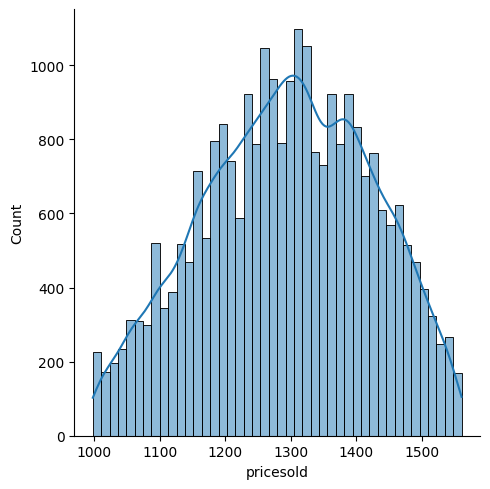

In [30]:

    # get rid of rare models

    # def delete_occurrences_fewer_than(data, model, threshold: int = 300) -> str:
    #     if len(data[data['Model'] == model]) < threshold:
    #         return 'Rare'
    #     return model
    #
    #
    # df['Model'] = df['Model'].apply(
    #     lambda x: delete_occurrences_fewer_than(data=df, model=x)
    # )
    #df = df.groupby('Model').map((lambda x: x.value_counts() < 200), 'Other')

    df = df.groupby('Make').filter(lambda x: len(x) > 100)
    df['Model'] = df['Model'].mask(df['Model'].map(df['Model'].value_counts()) < 100, np.NaN)
    df.drop('Make', inplace=True, axis=1)
    df = df.groupby('NumCylinders').filter(lambda x: len(x) > 100)

    df.dropna(subset=['Model'], inplace=True, axis=0)
    #df.corr()


    df = pd.get_dummies(data=df)
    # for col in df.columns:
    #     print(col)
    print(df.shape)


    # df_log2['pricesold'] = np.log2(df['pricesold'])

    # splitting
    # df_2019 = df[df["yearsold"] == 2019]
    # df_2020 = df[df["yearsold"] == 2019]
    # to_drop = ['yearsold']
    # df_2019.drop(to_drop, inplace=True, axis=1)
    # df_2020.drop(to_drop, inplace=True, axis=1)

    year_sold_patterns = [
        (df['yearsold'] == 2018, 1),
        (df['yearsold'] == 2019, 2),
        (df['yearsold'] == 2020, 3),
    ]

    criteria, values = zip(*year_sold_patterns)
    df['yearsold'] = np.select(criteria, values, np.NAN)
    df.dropna()


    # df_2019_target = df_2019.pop('pricesold')
    # df_2020_target = df_2020.pop('pricesold')

    percentiles_price = np.percentile(df.pricesold, [25, 50, 75])

    df_target = df.pop('pricesold')

    # price is log2, shown by graph
    df_target_log2 = np.log2(df_target) * 100
    sns.displot(data=df_target_log2, kde=True)
    plt.show()



In [31]:


    # test data

    x_train, x_test, y_train, y_test = train_test_split(df, df_target, test_size=0.2)

    # combine with price for test
    x_test["pricesold"] = y_test

    # make array from percentiles, to try
    percentiles_array = [x_test[x_test["pricesold"].between(0, percentiles_price[0])],
                         x_test[x_test["pricesold"].between(percentiles_price[0], percentiles_price[1])],
                         x_test[x_test["pricesold"].between(percentiles_price[1], percentiles_price[2])],
                         x_test[x_test["pricesold"].between(percentiles_price[2], 50000)]]

    x_test.pop('pricesold')

    # create separate array with price
    percentiles_targets = []
    for p in percentiles_array:
        print(len(p))
        percentiles_targets.append(p.pop('pricesold'))

    y_train_log2 = np.log2(y_train) * 100

    #train, val = train_test_split(train, test_size=0.2)
    print(len(x_train), 'train examples')
    #print(len(val), 'validation examples')
    print(len(x_test), 'test examples')



# sklearn regression

    # Defining MAPE function
    def MAPE(Y_actual, Y_Predicted):
        mape = np.mean(np.abs((Y_actual - Y_Predicted) / Y_actual)) * 100
        return mape

    # Defining prediction plot
    def PLOT_ACTUAL_VS_PREDICTED(Y_actual, Y_predicted, line_of_best_fit=True):

        # add points to plot
        plt.scatter(Y_actual, Y_predicted)
        plt.xlabel('actual price')
        plt.ylabel('predicted price')
        plt.title('actual and predicted price with line of best fit')
        plt.legend()
        plt.tight_layout()

        if(line_of_best_fit):
            # find line of best fit
            a, b = np.polyfit(Y_actual.flatten(), Y_predicted.flatten(), 1)

            # add line of best fit to plot
            plt.plot(Y_actual, a * Y_actual + b, color='purple', linewidth=6)
            plt.plot(Y_actual, Y_actual, color='blue', linewidth=6)
        plt.show()

1318
1375
1378
1271
21137 train examples
5285 test examples


Linear Regression:
linear MAPE: 45.08198331872247
linear RSME: 5905.264400577512
linear R2: 0.6433430994186815


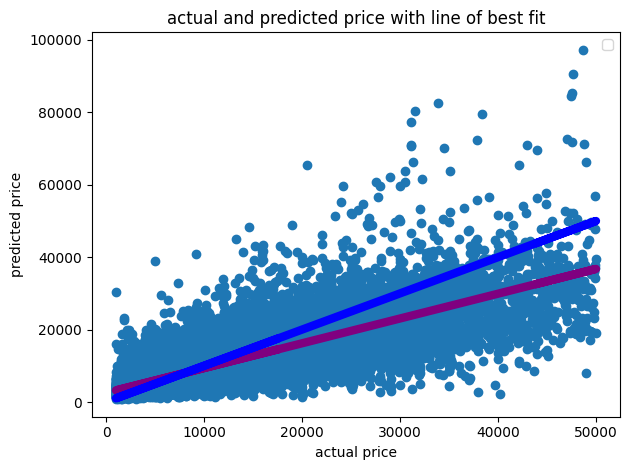

linear MAPE: 45.646879553490564
linear RSME: 5695.141952569237
linear R2: 0.6521519775140586


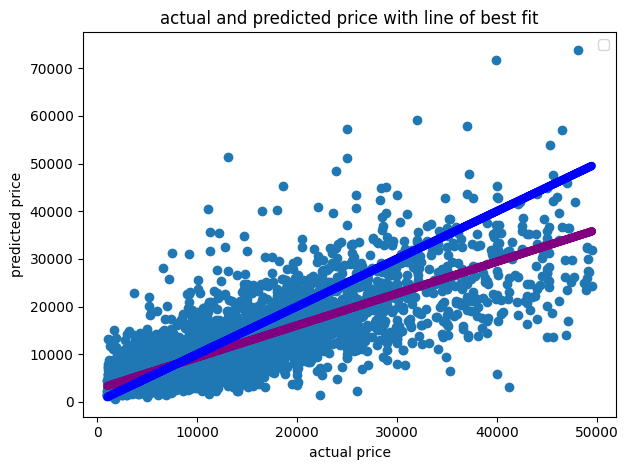

Ridge Regression:
ridge MAPE: 45.08200036968149
ridge RSME: 5905.1842293734335
ridge R2: 0.6433527834623164


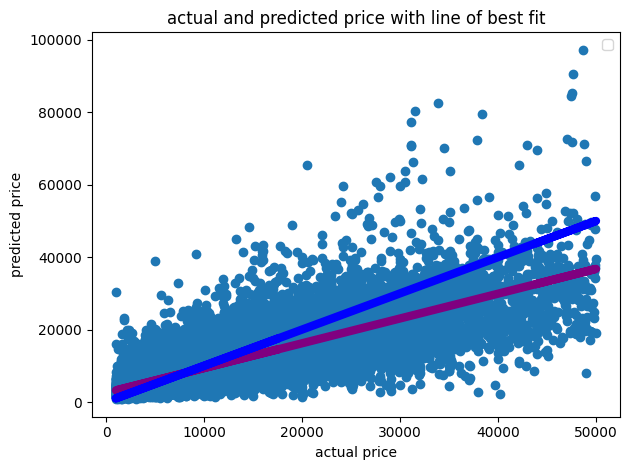

ridge MAPE: 45.646906498615216
ridge RSME: 5695.088874828717
ridge R2: 0.6521584612509683


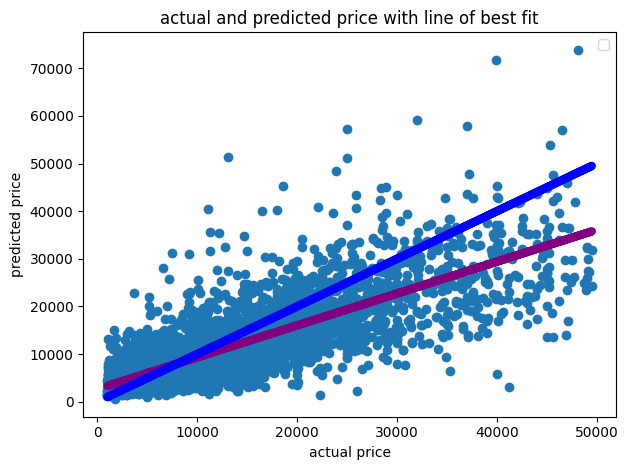

lasso MAPE: 45.107017552658974
lasso RSME: 5900.178847899164
lasso R2: 0.6439571333792987


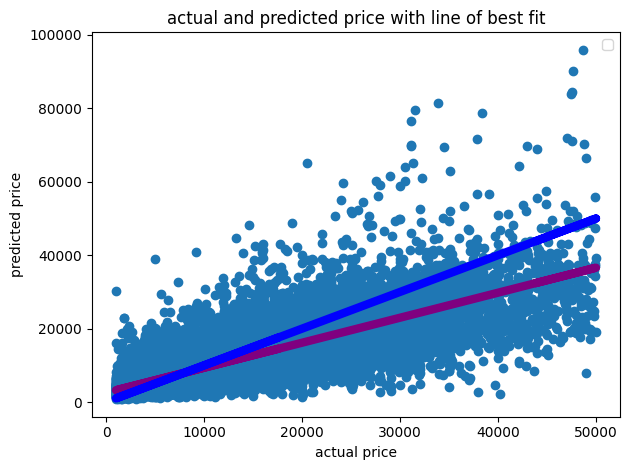

lasso MAPE: 45.69976889672033
lasso RSME: 5697.728745805404
lasso R2: 0.6518359133066849


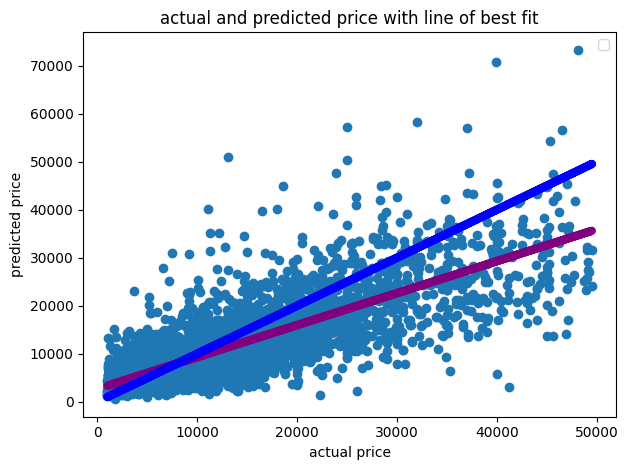

RF Regression:


RF MAPE: 12.845735105750142
RF RSME: 1969.7625157159212
RF R2: 0.960317440720095


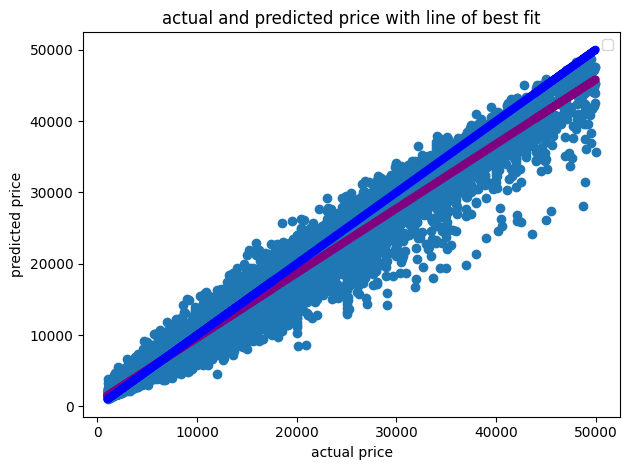

RF MAPE: 38.55323604986719
RF RSME: 4598.271112063224
RF R2: 0.773238365417882


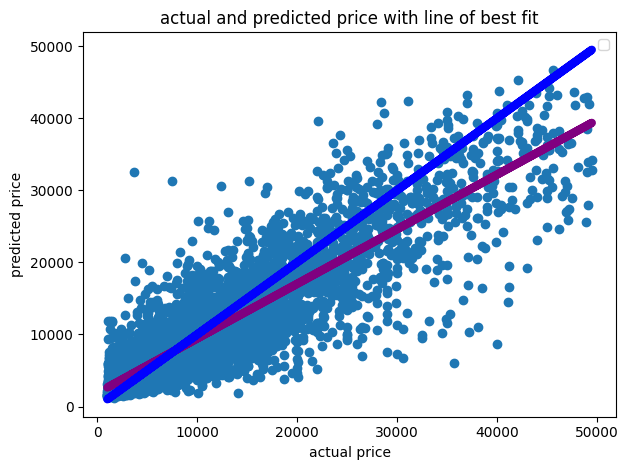

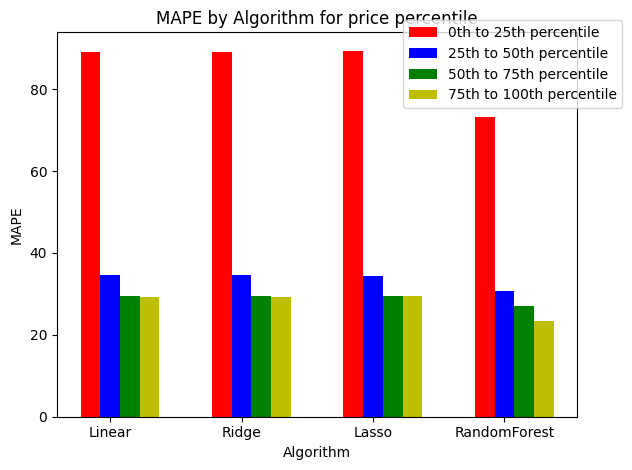

In [32]:


    # linear
    lr = LinearRegression()
    lr.fit(x_train, y_train_log2)
    print("Linear Regression:")

    # # predictions
    # for d in percentiles_array:
    #     pred_train_lr = lr.predict(x_train)
    #     pred_train_lr = np.exp2(pred_train_lr * 0.01)
    #     print(MAPE(y_train, pred_train_lr))

    # predictions
    pred_train_lr = lr.predict(x_train)
    pred_train_lr = np.exp2(pred_train_lr * 0.01)
    print("linear MAPE: "+str(MAPE(y_train, pred_train_lr)))
    print("linear RSME: "+str(np.sqrt(mean_squared_error(y_train, pred_train_lr))))
    print("linear R2: "+str(r2_score(y_train, pred_train_lr)))

    PLOT_ACTUAL_VS_PREDICTED(y_train.values, pred_train_lr)

    pred_test_lr = lr.predict(x_test)
    pred_test_lr = np.exp2(pred_test_lr * 0.01)
    print("linear MAPE: "+str(MAPE(y_test, pred_test_lr)))
    print("linear RSME: "+str(np.sqrt(mean_squared_error(y_test, pred_test_lr))))
    print("linear R2: "+str(r2_score(y_test, pred_test_lr)))

    PLOT_ACTUAL_VS_PREDICTED(y_test.values, pred_test_lr)

    # ridge
    rr = Ridge(alpha=0.01)
    rr.fit(x_train, y_train_log2)
    print("Ridge Regression:")

    # predictions
    pred_train_rr = rr.predict(x_train)
    pred_train_rr = np.exp2(pred_train_rr * 0.01)
    print("ridge MAPE: "+str(MAPE(y_train, pred_train_rr)))
    print("ridge RSME: "+str(np.sqrt(mean_squared_error(y_train, pred_train_rr))))
    print("ridge R2: "+str(r2_score(y_train, pred_train_rr)))

    PLOT_ACTUAL_VS_PREDICTED(y_train.values, pred_train_rr)

    pred_test_rr = rr.predict(x_test)
    pred_test_rr = np.exp2(pred_test_rr * 0.01)
    print("ridge MAPE: "+str(MAPE(y_test, pred_test_rr)))
    print("ridge RSME: "+str(np.sqrt(mean_squared_error(y_test, pred_test_rr))))
    print("ridge R2: "+str(r2_score(y_test, pred_test_rr)))

    PLOT_ACTUAL_VS_PREDICTED(y_test.values, pred_test_rr)


    # Lasso Regression
    model_lasso = Lasso(alpha=0.01)
    model_lasso.fit(x_train, y_train_log2)

    # predictions
    pred_train_lasso = model_lasso.predict(x_train)
    pred_train_lasso = np.exp2(pred_train_lasso * 0.01)
    print("lasso MAPE: "+str(MAPE(y_train, pred_train_lasso)))
    print("lasso RSME: "+str(np.sqrt(mean_squared_error(y_train, pred_train_lasso))))
    print("lasso R2: "+str(r2_score(y_train, pred_train_lasso)))

    PLOT_ACTUAL_VS_PREDICTED(y_train.values, pred_train_lasso)

    pred_test_lasso = model_lasso.predict(x_test)
    pred_test_lasso = np.exp2(pred_test_lasso * 0.01)
    print("lasso MAPE: "+str(MAPE(y_test, pred_test_lasso)))
    print("lasso RSME: "+str(np.sqrt(mean_squared_error(y_test, pred_test_lasso))))
    print("lasso R2: "+str(r2_score(y_test, pred_test_lasso)))

    PLOT_ACTUAL_VS_PREDICTED(y_test.values, pred_test_lasso)


    # Random Forest Regression
    # important to test many times because it is stochastic
    # get a list of models to evaluate
    # def get_models():
    #     models = dict()
    #     # exp2lore number of features from 1 to 7
    #     for i in range(4, 6):
    #         models[str(i)] = RandomForestClassifier(max_features=i)
    #     return models
    #
    # # evaluate a given model using cross-validation
    # def evaluate_model(model, X, y):
    #     # define the evaluation procedure
    #     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    #     # evaluate the model and collect the results
    #     scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    #     return scores

    # Random Forest
    rf = RandomForestRegressor(random_state=0)
    rf.fit(x_train, y_train_log2)
    print("RF Regression:")

    # predictions
    pred_train_rf = rf.predict(x_train)
    pred_train_rf = np.exp2(pred_train_rf * 0.01)
    print("RF MAPE: "+str(MAPE(y_train, pred_train_rf)))
    print("RF RSME: "+str(np.sqrt(mean_squared_error(y_train, pred_train_rf))))
    print("RF R2: "+str(r2_score(y_train, pred_train_rf)))

    PLOT_ACTUAL_VS_PREDICTED(y_train.values, pred_train_rf)

    pred_test_rf = rf.predict(x_test)
    pred_test_rf = np.exp2(pred_test_rf * 0.01)
    print("RF MAPE: "+str(MAPE(y_test, pred_test_rf)))
    print("RF RSME: "+str(np.sqrt(mean_squared_error(y_test, pred_test_rf))))
    print("RF R2: "+str(r2_score(y_test, pred_test_rf)))

    PLOT_ACTUAL_VS_PREDICTED(y_test.values, pred_test_rf)


# Get MAPE boxplot


    def graph_MAPE_by_price(array_to_predict):

        # create plot
        fig, ax = plt.subplots()
        index = np.arange(4)
        bar_width = 0.15
        opacity = 1
        colors = ['r', 'b', 'g', 'y']

        for i in range(4):

            results = []

            # lr
            pred_test = lr.predict(array_to_predict[i])
            pred_test = np.exp2(pred_test * 0.01)
            results.append(MAPE(percentiles_targets[i], pred_test))

            # rr
            pred_test = rr.predict(array_to_predict[i])
            pred_test = np.exp2(pred_test * 0.01)
            results.append(MAPE(percentiles_targets[i], pred_test))

            # lasso_r
            pred_test = model_lasso.predict(array_to_predict[i])
            pred_test = np.exp2(pred_test * 0.01)
            results.append(MAPE(percentiles_targets[i], pred_test))

            # rf
            pred_test = rf.predict(array_to_predict[i])
            pred_test = np.exp2(pred_test * 0.01)
            results.append(MAPE(percentiles_targets[i], pred_test))

            rects = plt.bar(index + bar_width * i, results, bar_width,
                            alpha=opacity,
                            color=colors[i],
                            label=str(i * 25) + 'th to '+str((i+1) * 25) + 'th percentile')

        plt.xlabel('Algorithm')
        plt.ylabel('MAPE')
        plt.title('MAPE by Algorithm for price percentile')
        plt.xticks(index + bar_width, ('Linear', 'Ridge', 'Lasso', 'RandomForest'))
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
        plt.show()


    graph_MAPE_by_price(percentiles_array)


    # numeric features
    # numeric_feature_names = ['mileage', 'hp', 'year']
    # numeric_features = df[numeric_feature_names]
    # numeric_features.sort_values(['hp'], axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last', ignore_index=False, key=None)
    # print(numeric_features)
    # print(numeric_features.dtypes)
    # print(numeric_features.shape)


# plot the density histograms

    def increment_year(dataframe):
        dataframe["Year"] += 1
        dataframe["yearsold"] += 1
        dataframe["Mileage"] += 14263

    # return average prediction list from dataframe array
    # feed for one year
    # return list for 2019, 2018
    def get_average_prediction(df_arr):

        def percentage_difference(result_old, result_new):
            result_old = np.average(np.exp2(result_old * 0.01))
            result_new = np.average(np.exp2(result_new * 0.01))
            decrease = result_old - result_new
            return (decrease / result_old) * 100

        linreg = percentage_difference(lr.predict(df_arr[0]), lr.predict(df_arr[1]))
        ridgereg = percentage_difference(rr.predict(df_arr[0]), rr.predict(df_arr[1]))
        lassoreg = percentage_difference(model_lasso.predict(df_arr[0]), model_lasso.predict(df_arr[1]))
        randomreg = percentage_difference(rf.predict(df_arr[0]), rf.predict(df_arr[1]))

        # return tuple with all data for one year
        # actual data too?
        return linreg, ridgereg, lassoreg, randomreg




In [33]:
newer_depreciation = [0.2, 0.3, 0.4, 0.5]
older_depreciation = [0.6, 0.7, 0.8, 0.9]
pred_test_rr = [10000, 11000, 12000, 13000]
pred_test_lasso = [11000, 12000, 13000, 14000]
pred_test_rf = [12000, 13000, 14000, 15000]
pred_test_lr = [13000, 14000, 15000, 16000]

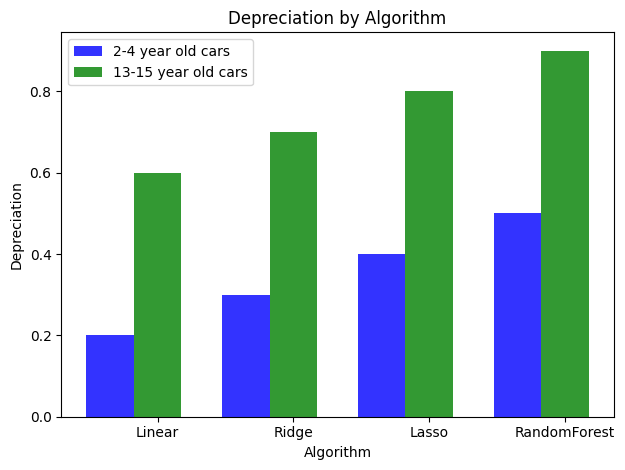

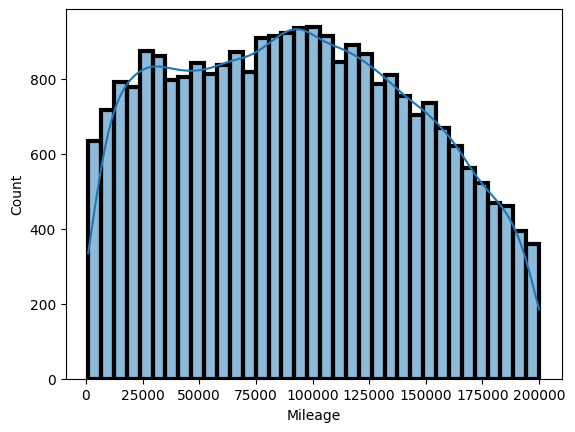

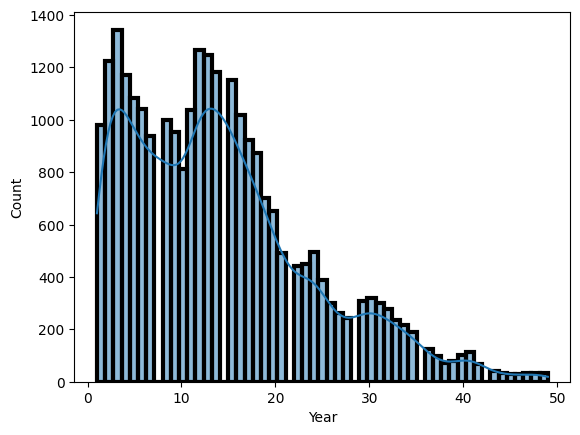

In [34]:
# create plot
fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, newer_depreciation, bar_width,
                 alpha=opacity,
                 color='b',
                 label='2-4 year old cars')

rects2 = plt.bar(index + bar_width, older_depreciation, bar_width,
                 alpha=opacity,
                 color='g',
                 label='13-15 year old cars')

plt.xlabel('Algorithm')
plt.ylabel('Depreciation')
plt.title('Depreciation by Algorithm')
plt.xticks(index + bar_width, ('Linear', 'Ridge', 'Lasso', 'RandomForest'))
plt.legend()
plt.tight_layout()
plt.show()

# find the most common occurrences all columns in dataframe
# most common mileage: 100,000
sns.histplot(df['Mileage'], kde=True, linewidth=3, label="mileage")
plt.show()


# most common Year: 5-15
sns.histplot(df['Year'], kde=True, linewidth=3, label="mileage")
plt.show()



